# This includes the modified model class that stores the generated data

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics
import shap
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [27]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_38524\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [28]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [29]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [30]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [31]:
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [32]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [33]:
data = data.sample(n=10000)

In [34]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    6983
1    1017
Name: count, dtype: int64
Test label
0    1741
1     259
Name: count, dtype: int64


In [35]:
train_sample = X_train.sample(n=1000)
train_sample_tensor = torch.tensor(train_sample.values, dtype=torch.float32)
test_sample = X_test.sample(n=1000)
test_sample_tensor = torch.tensor(test_sample.values, dtype=torch.float32)

In [36]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model1 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 63/63 [00:01<00:00, 55.07batch/s]


Epoch [1/5], Train Loss: 0.0858, Train Acc: 0.9690, Train F1: 0.9610


Epoch 2/5: 100%|██████████| 63/63 [00:01<00:00, 59.43batch/s]


Epoch [2/5], Train Loss: 0.0199, Train Acc: 0.9912, Train F1: 0.9912


Epoch 3/5: 100%|██████████| 63/63 [00:01<00:00, 57.32batch/s]


Epoch [3/5], Train Loss: 0.0184, Train Acc: 0.9912, Train F1: 0.9911


Epoch 4/5: 100%|██████████| 63/63 [00:01<00:00, 54.50batch/s]


Epoch [4/5], Train Loss: 0.0155, Train Acc: 0.9923, Train F1: 0.9923


Epoch 5/5: 100%|██████████| 63/63 [00:01<00:00, 50.69batch/s]


Epoch [5/5], Train Loss: 0.0144, Train Acc: 0.9929, Train F1: 0.9928


Testing: 100%|██████████| 16/16 [00:00<00:00, 320.02batch/s]


Test Loss: 0.0216, Test Accuracy: 0.9897, Test F1: 0.9899


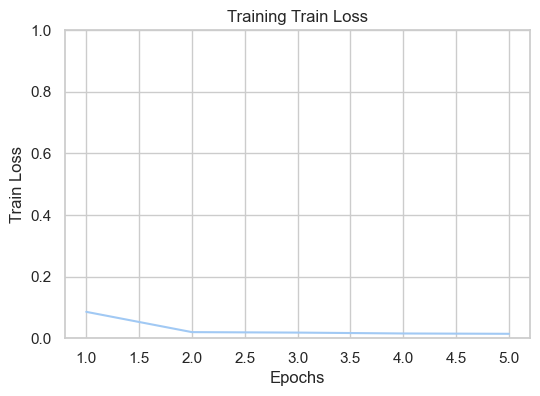

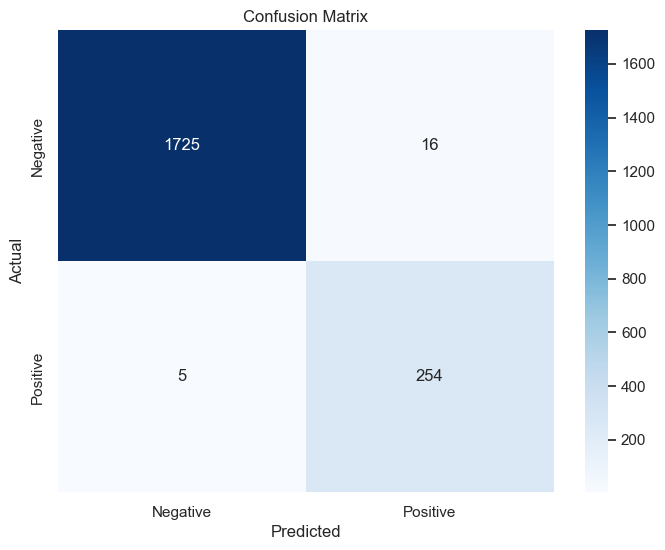

In [38]:
sampler = 'tomeks'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.01
epochs = 5
save_factor = 100
# Required for real train background.
store_data = True
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model2 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 63/63 [00:00<00:00, 189.33batch/s]


Epoch [1/5], Train Loss: 0.0850, Train Acc: 0.9692, Train F1: 0.9622


Epoch 2/5: 100%|██████████| 63/63 [00:00<00:00, 212.26batch/s]


Epoch [2/5], Train Loss: 0.0212, Train Acc: 0.9898, Train F1: 0.9897


Epoch 3/5: 100%|██████████| 63/63 [00:00<00:00, 241.78batch/s]


Epoch [3/5], Train Loss: 0.0199, Train Acc: 0.9911, Train F1: 0.9910


Epoch 4/5: 100%|██████████| 63/63 [00:00<00:00, 236.52batch/s]


Epoch [4/5], Train Loss: 0.0175, Train Acc: 0.9919, Train F1: 0.9918


Epoch 5/5: 100%|██████████| 63/63 [00:00<00:00, 226.01batch/s]


Epoch [5/5], Train Loss: 0.0164, Train Acc: 0.9922, Train F1: 0.9921


Testing: 100%|██████████| 16/16 [00:00<00:00, 289.38batch/s]

Test Loss: 0.0180, Test Accuracy: 0.9937, Test F1: 0.9936


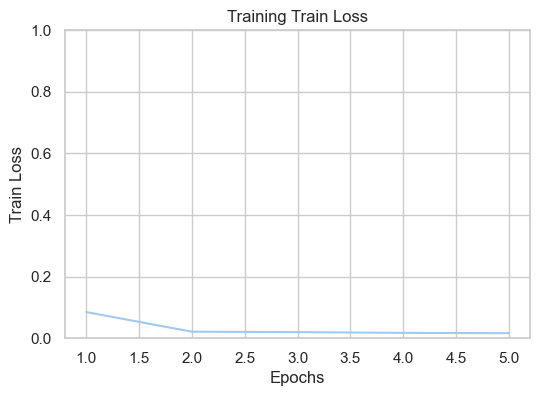

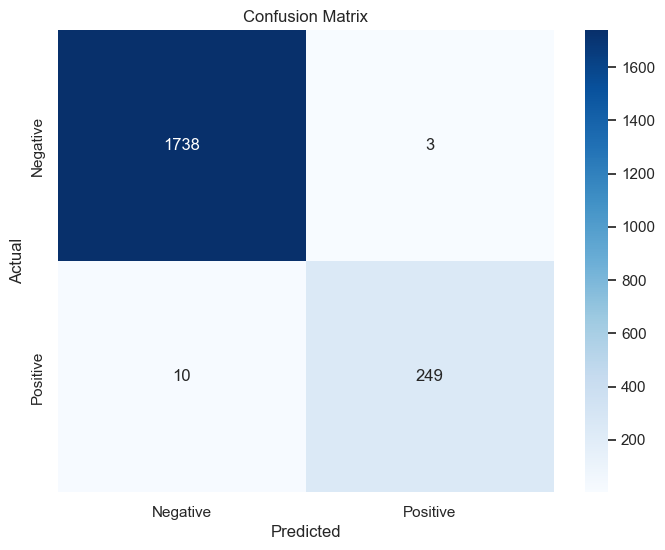

In [40]:
sampler = None
params = None
learning_rate = 0.01
epochs = 5
save_factor = 100
store_data = False
model2.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data)
model2.test(test_loader)
plot_metrics(model2.train_loss, len(model2.train_loss), title="Train Loss")
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model2.test_predicted)

Evaluation on Train Background

Sampled

In [ ]:
# Train Background.
# 3.55 min
xp1 = shap.DeepExplainer(model1, X_train_tensor)
shap1 = xp1.shap_values(X_test_tensor)

In [ ]:
# Sampled Train Background and shap values.
xp2 = shap.DeepExplainer(model1, model1.s_X)
shap2 = xp2.shap_values(X_test_tensor)

In [ ]:
# Sample Background.
# 30.7 seconds
idx = torch.randperm(model1.s_X.size(0))[:1000]
s_X_sample = model1.s_X[idx]
xp3 = shap.DeepExplainer(model1, s_X_sample)
shap3 = xp3.shap_values(X_test_tensor)

In [ ]:
# Test Background.
# 58.8 seconds
xp4 = shap.DeepExplainer(model1,X_test_tensor)
shap4 = xp4.shap_values(X_test_tensor)

Standard

In [ ]:
# Train Background.
# 3.6 min
xp5 = shap.DeepExplainer(model2, X_train_tensor)
shap5 = xp5.shap_values(X_test_tensor)

In [ ]:
# Test Background
# 58.2 seconds.
xp6 = shap.DeepExplainer(model2, X_test_tensor)
shap6 = xp6.shap_values(X_test_tensor)

# Select Sparse and Non-Sparse from Previous Test

In [55]:
cols = [225, 40, 16, 11, 211, 224, 271, 31, 32, 13, 217, 175, 251, 8, 180, 43, 274, 186, 254, 6]
names = X_train[X_train.columns[[225, 40, 16, 11, 211, 224, 271, 31, 32, 13, 217, 175, 251, 8, 180, 43, 274, 186, 254, 6]]].columns
print(names)

Index(['state_CON', 'proto_tcp', 'dmeansz', 'swin', 'service_none',
       'state_FIN', 'sport_1043', 'ct_srv_src', 'ct_srv_dst', 'stcpb',
       'service_ssh', 'dsport_5190', 'srcip_149.171.126.12', 'dload',
       'dsport_22', 'proto_arp', 'sport_138', 'dsport_138',
       'srcip_10.40.182.6', 'dloss'],
      dtype='object')


Sampled

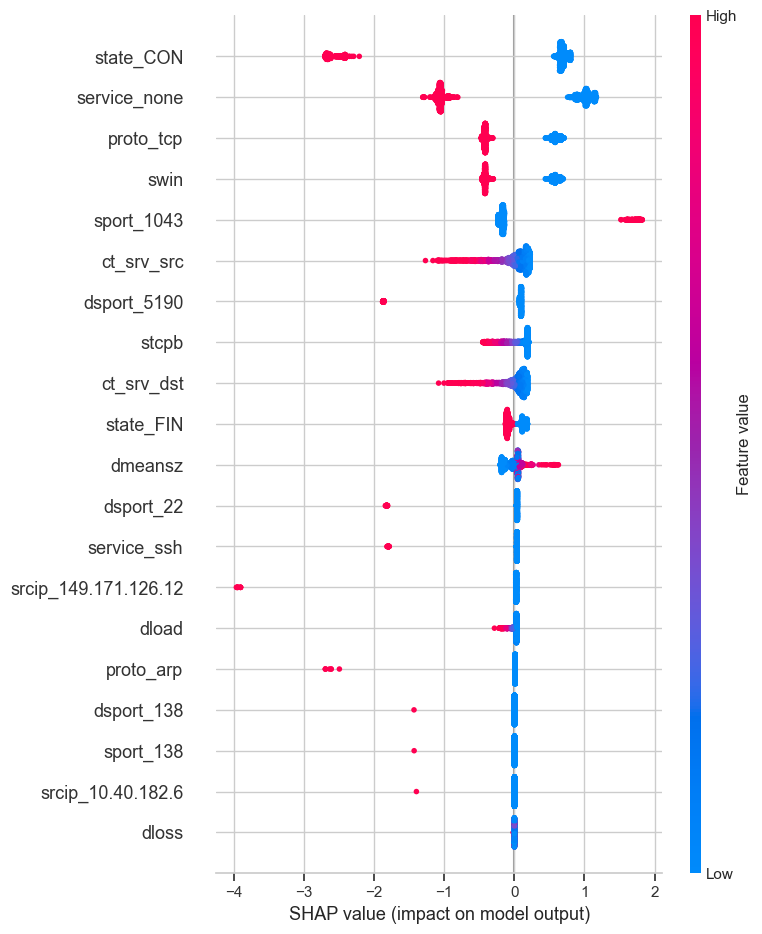

In [56]:
shap.summary_plot(shap1.squeeze()[:, cols], X_test_tensor[:, cols], feature_names=names)

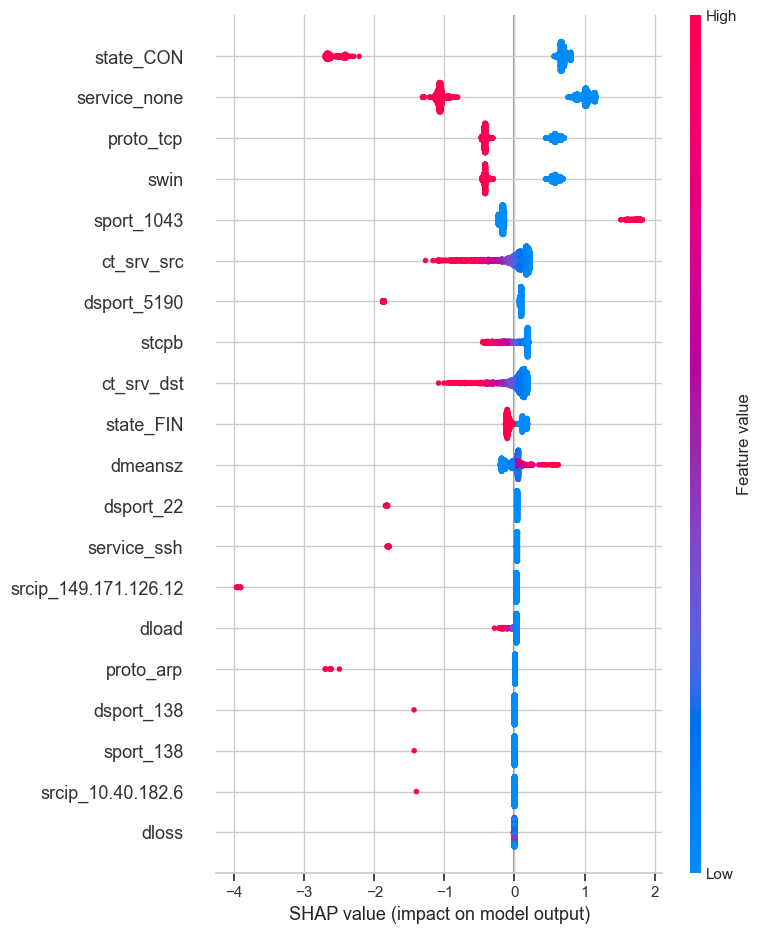

In [57]:
shap.summary_plot(shap2.squeeze()[:, cols], X_test_tensor[:, cols], feature_names=names)

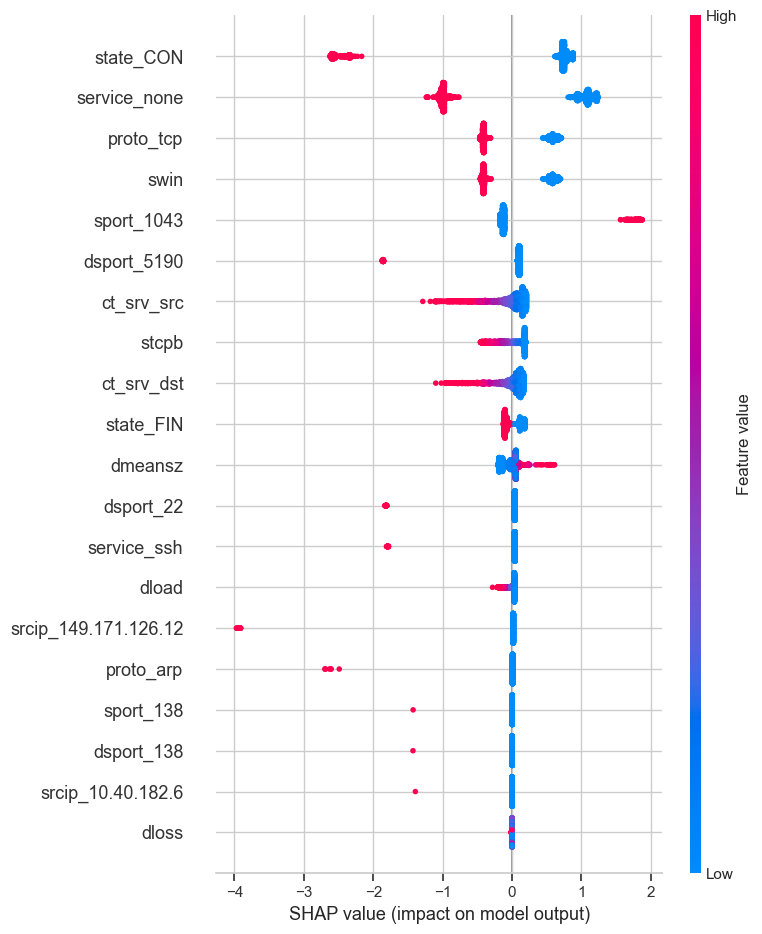

In [58]:
shap.summary_plot(shap3.squeeze()[:, cols], X_test_tensor[:, cols], feature_names=names)

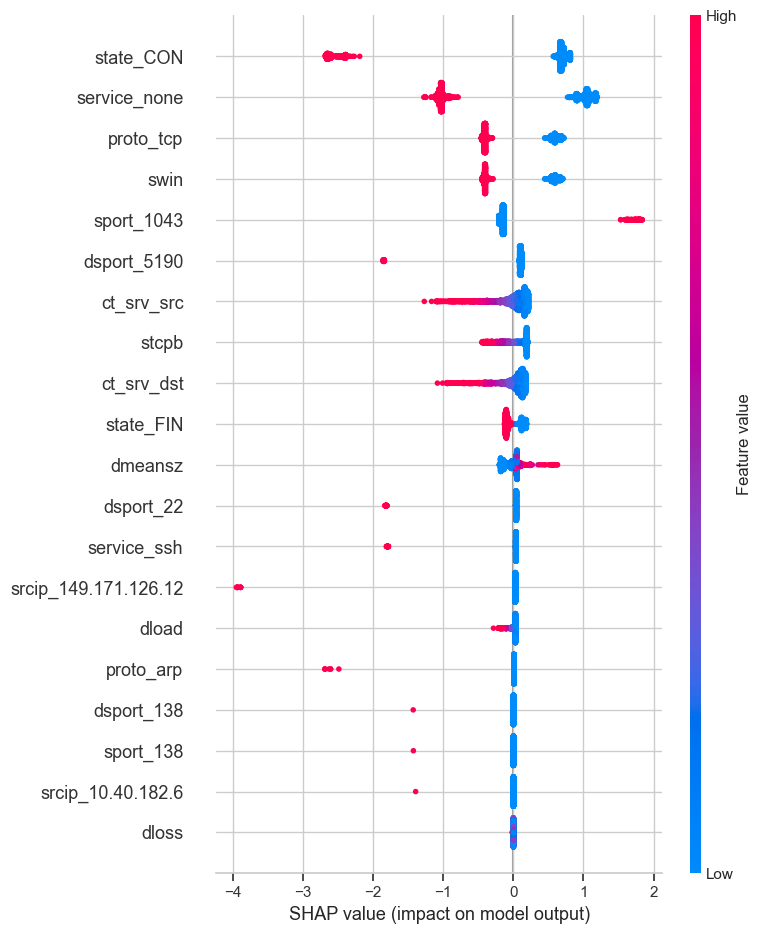

In [59]:
shap.summary_plot(shap4.squeeze()[:, cols], X_test_tensor[:, cols], feature_names=names)

Standard

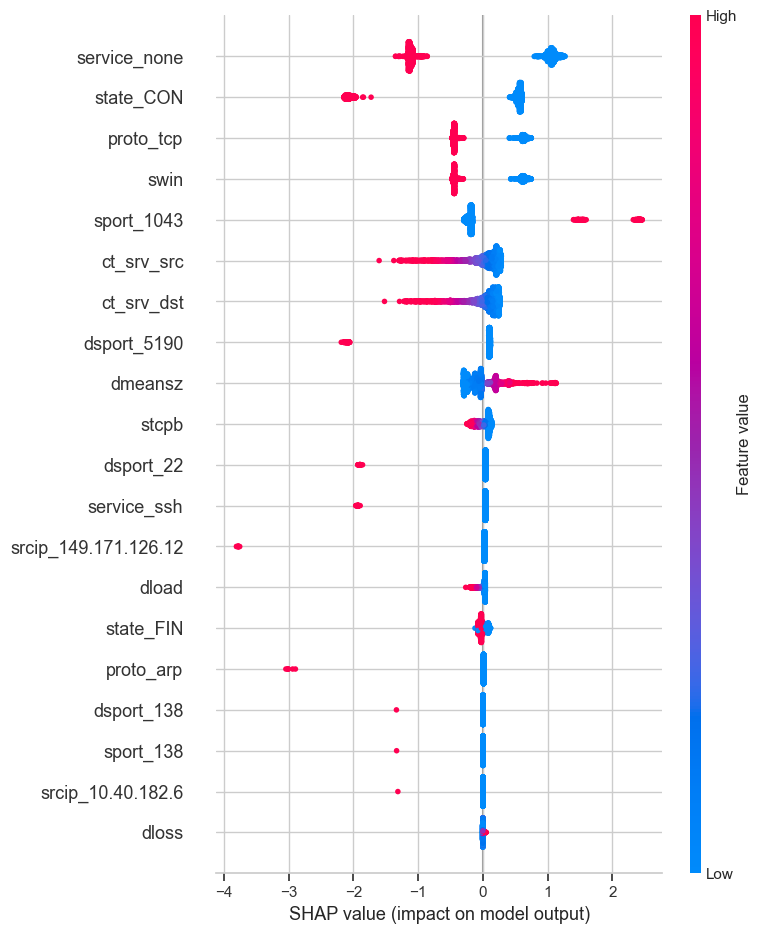

In [60]:
shap.summary_plot(shap5.squeeze()[:, cols], X_test_tensor[:, cols], feature_names=names)

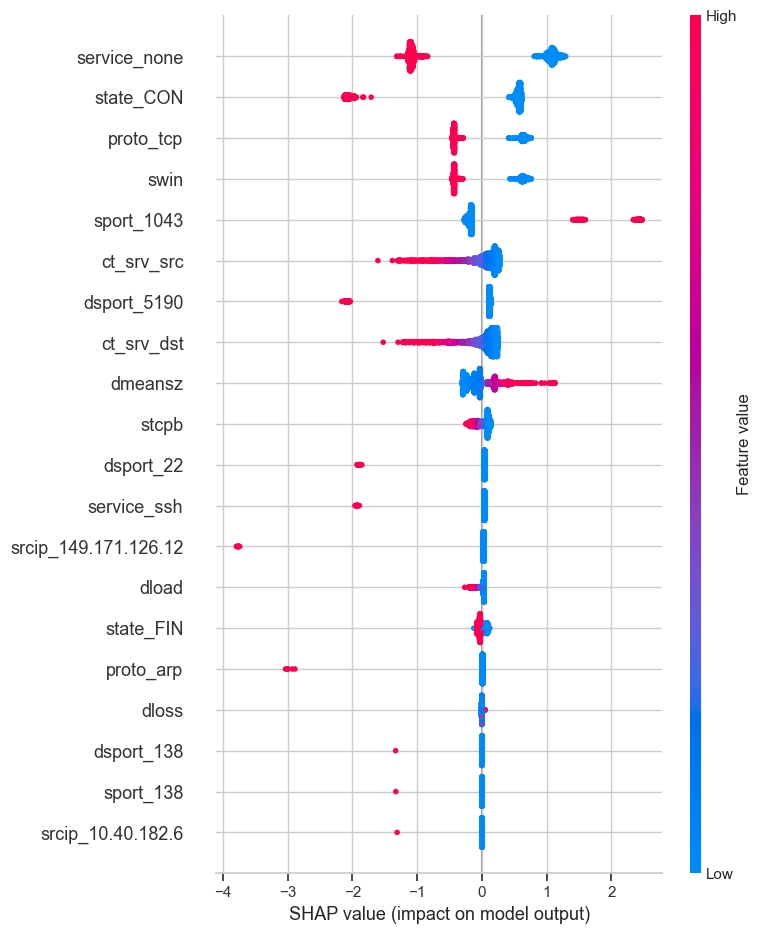

In [61]:
shap.summary_plot(shap6.squeeze()[:, cols], X_test_tensor[:, cols], feature_names=names)